In [58]:
import torch
import os
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

CURRENT_DIR = os.path.dirname(os.path.abspath("__file__"))


In [59]:
# Load the pre-trained model
model = maskrcnn_resnet50_fpn(pretrained=True)
model = model.eval()

# Load your image
image = Image.open(os.path.join(CURRENT_DIR, '..', 'dataset', 'rawimages', "Ganglioneuroblastoma_0.tif")).convert("L")

In [60]:
def predict(img: Image.Image, model) -> torch.Tensor:
    image_tensor = F.to_tensor(image)
    # Add an extra dimension at the beginning of the tensor, which represents the batch size
    image_tensor = image_tensor.unsqueeze(0)

    # Check for GPU availability and if available, move the model and input tensor to GPU
    if torch.cuda.is_available():
        model = model.cuda()
        image_tensor = image_tensor.cuda()

    # Perform inference
    with torch.no_grad():
        prediction = model(image_tensor)
        return prediction

In [61]:
prediction = predict(img=image, model=model)
prediction

[{'boxes': tensor([[  11.5696,    0.0000, 1225.0000,  900.4765],
          [  54.8186,    3.4485, 1209.5342,  914.0001]]),
  'labels': tensor([64, 85]),
  'scores': tensor([0.0865, 0.0539]),
  'masks': tensor([[[[0.0546, 0.0602, 0.0657,  ..., 0.0941, 0.0903, 0.0865],
            [0.0579, 0.0638, 0.0697,  ..., 0.0998, 0.0958, 0.0918],
            [0.0613, 0.0675, 0.0737,  ..., 0.1055, 0.1013, 0.0970],
            ...,
            [0.0170, 0.0188, 0.0205,  ..., 0.0375, 0.0360, 0.0345],
            [0.0139, 0.0153, 0.0167,  ..., 0.0306, 0.0294, 0.0281],
            [0.0107, 0.0118, 0.0129,  ..., 0.0237, 0.0227, 0.0218]]],
  
  
          [[[0.0000, 0.0000, 0.0000,  ..., 0.0380, 0.0332, 0.0284],
            [0.0000, 0.0000, 0.0000,  ..., 0.0409, 0.0357, 0.0305],
            [0.0000, 0.0000, 0.0000,  ..., 0.0438, 0.0382, 0.0326],
            ...,
            [0.0000, 0.0000, 0.0000,  ..., 0.0618, 0.0539, 0.0461],
            [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.0511, 0.0437],
          

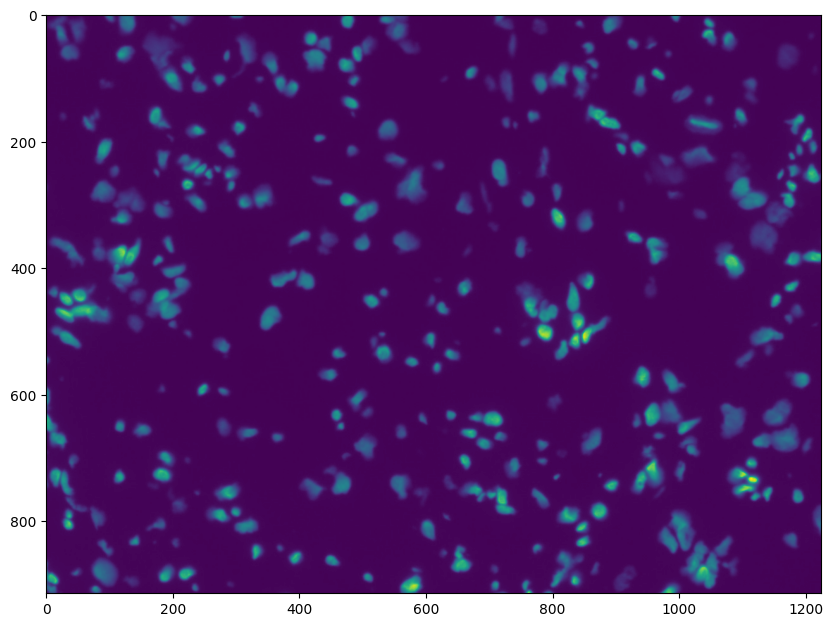

In [62]:
plt.figure(figsize=(10, 10))
plt.imshow(image)

In [63]:
def plot_prediction(prediction, threshold, image):
    pred = prediction[0]

    # The masks are binary masks of shape (N, 1, H, W),
    # where N is the number of predicted masks (i.e., number of instances),
    # H and W are the height and width of the masks
    masks = pred['masks'].cpu().detach().numpy()
    scores = pred['scores'].cpu().detach().numpy()
    boxes = pred['boxes'].cpu().detach().numpy()

    # Create a figure and axes
    fig, ax = plt.subplots(1, figsize=(15, 15))

    # Display the image
    ax.imshow(image)
    
    # For each mask
    for i in range(masks.shape[0]):
        # Draw the mask
        mask = masks[i][0]
        ax.imshow(mask > threshold, alpha=0.3)

        # Draw the bounding box
        box = boxes[i]
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

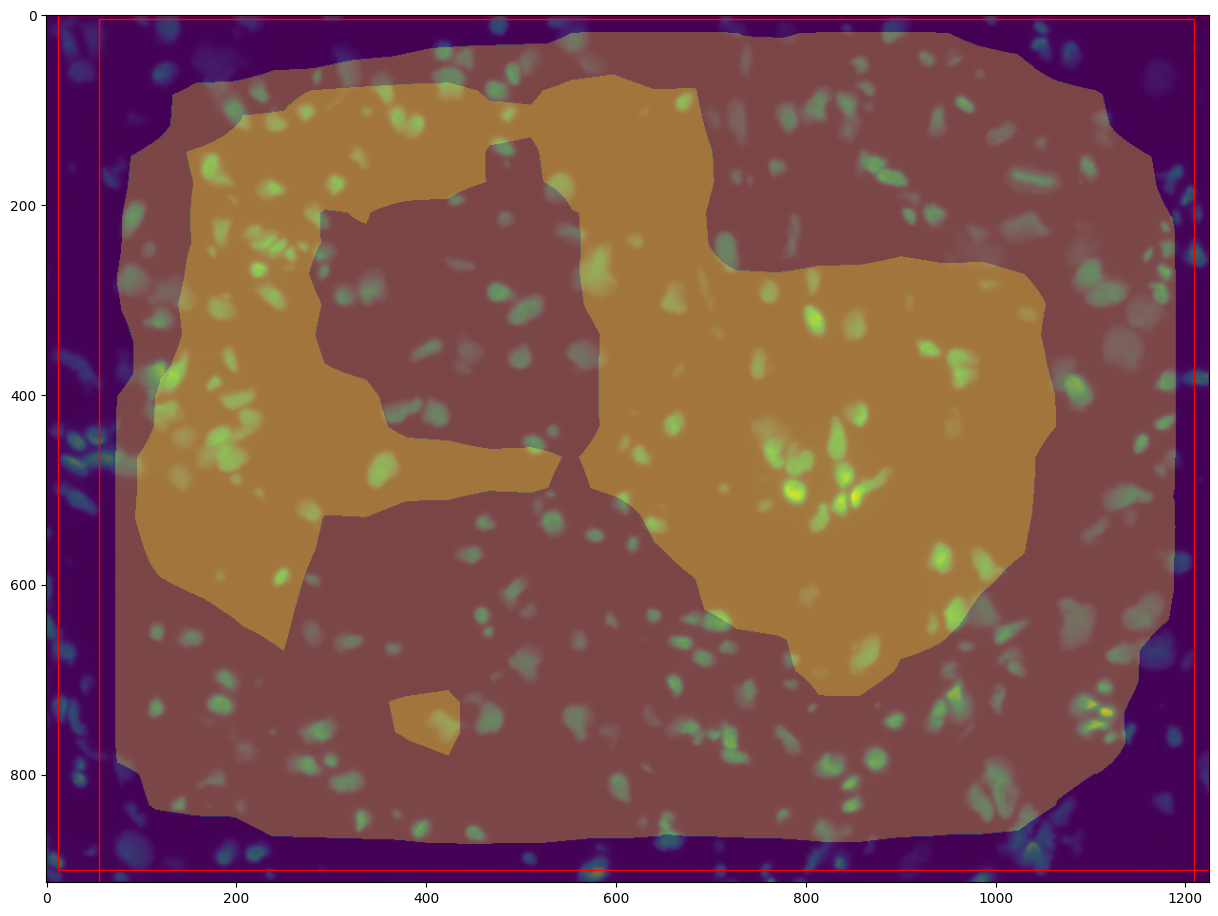

In [64]:
plot_prediction(prediction, threshold=0.9, image=image)

## Check pretrained model

In [65]:
from models.maskrcnn import MaskRCNN

In [66]:
model = MaskRCNN.from_pretrained(
    path="../saved_models/maskrcnn_epoch_99.pth",
    gpu=False,
)
model.eval()

In [67]:
X = Image.open(os.path.join(CURRENT_DIR, '..', 'dataset', 'rawimages', "Ganglioneuroblastoma_0.tif")).convert("L")
y = Image.open(os.path.join(CURRENT_DIR, '..', 'dataset', 'groundtruth', "Ganglioneuroblastoma_0.tif")).convert("L")

In [68]:
%%time
prediction = predict(img=X, model=model)

CPU times: user 2.22 s, sys: 931 ms, total: 3.16 s
Wall time: 1.58 s


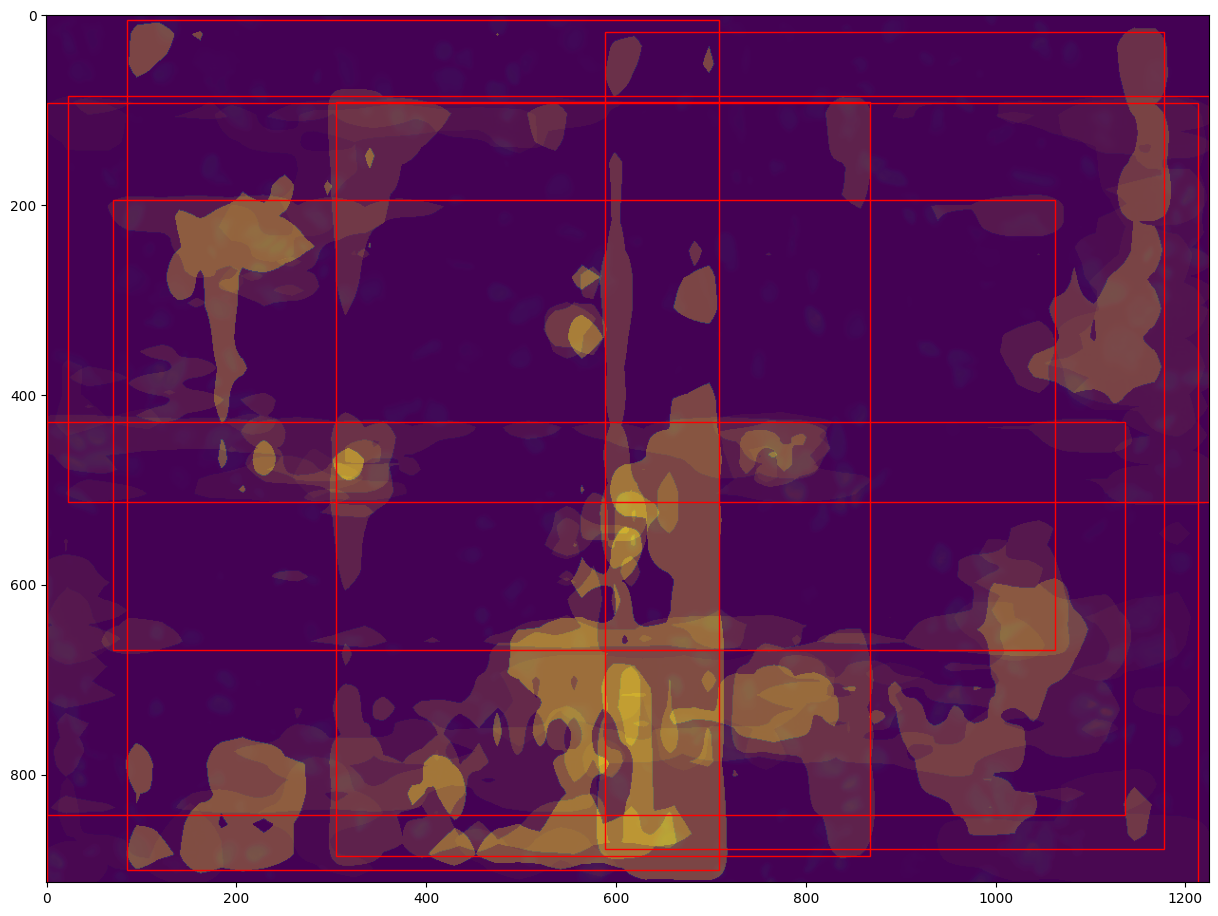

In [72]:
plot_prediction(prediction, threshold=0.001, image=X)

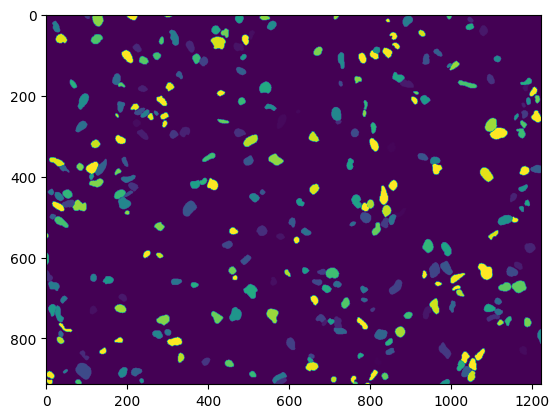

In [73]:
plt.imshow(y)